In [3]:

from scipy.stats.qmc import LatinHypercube as LHSampler
from scipy.stats import qmc 
from scipy.integrate import quad, dblquad, tplquad
from matplotlib import pyplot as plt
import numpy as np
from src.utils import plotLHS, concat, H
from src.eLHS_old import *
import json
from math import floor, ceil
from src.fancyplotter import usePlotSampleSet, SampleSetPlot
from typing import Callable, Generator
from latinexpansion import grade

LHS = LHSampler(d = 2)
err = 1e-9



In [80]:
#utility functions
class Experiment:
    def __init__(self, id:str, data, description:str):
        self.id = id
        self.datalist = data
        self.description = description
    
    def toJSON(self):
        return json.dumps(
            self,
            default=lambda o: o.__dict__, 
            sort_keys=True,
            indent=0)
    
    def instanceToJSON(obj):
        obj = Experiment(obj["id"], obj["datalist"], obj["description"])
        return obj.toJSON()

def expsave(id:str, data, mode:str, description: str = ""):
    if(mode == "w"):
        with open("./data/" + id + ".json", "w+") as f:
            experiment = Experiment(id, [data], description)
            f.write(experiment.toJSON())
    elif(mode == "a"):
        prevexp = expget(id)
        prevexp["datalist"].append(data)
        if description != "" and description is not None:
            prevexp["description"] = description
        with open("./data/" + id + ".json", "w+") as f:
            f.write(Experiment.instanceToJSON(prevexp))

def expget(id:str):
    f = open("./data/" + id + ".json", "r")
    return json.loads(f.read())

# P-dimensional Reimann integration 

In [228]:
class midpointIntegration:
    def __init__(self, d:int):
        if d <= 0:
            raise ValueError("Dimension must be positive")
        self.d = d
    
    def __gen_indexes(self, Ns, borders = False) -> Generator[list, None, None]:
        index = [0] * self.d
        if not borders:
            Ns = (np.array(Ns) - 1).tolist()
        yield index
        for _ in range(np.prod(Ns)):
            for p in reversed(range(self.d)):
                if index[p] + 1 == Ns[p]:
                    if p == 0:
                        return
                    index[p] = 0
                else:
                    index[p] += 1
                    break
            yield index

    def __relindex(self, abs_index: int, Ns: list[int]):
        rel = np.zeros((self.d), dtype=int)
        r = abs_index
        for p in range(0, self.d):
            rel[p] = floor(r/Ns[p])
            r = r % Ns[p]
        rel[-1] = r
        return rel

    def __absindex(self, rel_index:list[int], Ns:list[int]):
        abs = 0
        for p in range(0, self.d - 1):
            abs += Ns[p] * rel_index[p]
        abs += rel_index[-1]
        return abs

    def __shift_on_axis(self, index, axis: int, Ns: list[int], increment: int = 1):
        if type(index) is int:
            index = self.__relindex(index, Ns)
        rtr = [*index]
        rtr[axis] += increment
        if type(index) is int:
            return self.__absindex(rtr)
        else:
            return rtr

    def midpoint(self, xs, index: list[int], Ns: list[int]):
        m = np.zeros((self.d))
        for p in range(self.d):
            shifted_index = self.__shift_on_axis(index, p, Ns)
            m[p] = (xs[*index, p] + xs[*shifted_index, p])/2
        return m

    # lbs = lower_boundaries
    # ubs = upper_boundaries
    def integrate(self, f:Callable, Ns:list[int], lbs: list[int], ubs: list[int], xs):
        if len(Ns) != self.d:
            raise ValueError("Ns must be a list of integers ", self.d, " long")
        
        xs = np.zeros((*Ns, self.d))
        for i in self.__gen_indexes(Ns, borders = True):
            xs[*i] = [((i[k]/Ns[k])*(ubs[k] - lbs[k]))+lbs[k] for k in range(self.d)]
            # xs[*i] = np.linspace(lbs[], ubs[k],)
         
        I = 0
        for i in self.__gen_indexes(Ns, borders = False):
            I += f(self.midpoint(xs, i, Ns))
        I *= 1/np.prod(Ns)
        return I

def fun3(x):
    return 3*np.sin(x[0])*(np.cos(x[1])**3)

def fun4(x):
    return 3*np.sin(x[0])*(np.cos(x[1])**3) - np.exp(-x[2])**(x[1]+0.5)

def fun5(x):
    return 3*x[1]*x[0]**2 + x[2]*x[1]**3 - x[0]

d = 3
calc = midpointIntegration(d)
# lbs, ubs = [0] * d, [1] * d
lbs, ubs = [0, 0, 0], [1, 1, 1]
Ns = [100] * d
calc.integrate(fun4, Ns, lbs, ubs)


0.23599343667553838

In [229]:
tplquad(lambda *x: fun4(x), 0, 1, 0, 1, 0, 1)


(0.24770996991554128, 1.0122722908868418e-14)

In [235]:
# from https://en.wikipedia.org/wiki/Monte_Carlo_integration#Python_example
throws = 20000
inside_circle = 0
i = 0
radius = 1
while i < throws:
    # Choose random X and Y centered around 0,0
    x = np.random.uniform(-radius, radius)
    y = np.random.uniform(-radius, radius)
    # If the point is inside circle, increase variable
    if x**2 + y**2 <= radius**2:
        inside_circle += 1
    i += 1

# Calculate area and print; should be closer to Pi with increasing number of throws
area = (((2 * radius) ** 2) * inside_circle) / throws
print(area)

3.1286


## Monte Carlo Simulation

In [275]:
# monte-carlo simulation
def MCSim(f:Callable, xs: np.ndarray, V: float):
    N, _ = xs.shape
    I = (V/N) * np.sum(np.apply_along_axis(f, 1, xs))
    return I

### MCSim 2-D with Sobol and LHS

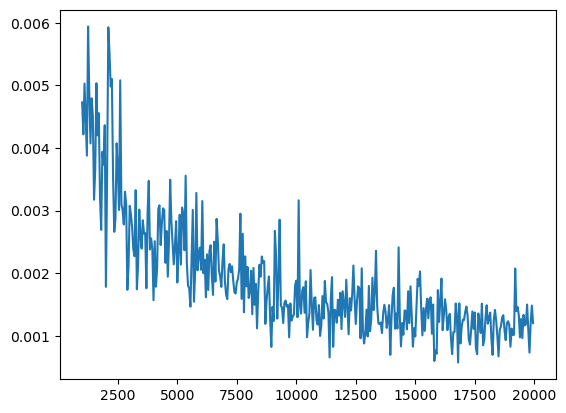

In [365]:

perfres = dblquad(lambda *x: fun3(x), 0, 1, 0, 1)[0]

Nstart, Nmax, step, iter = 1000, 20000, 50, 10
ns = np.arange(Nstart, Nmax, step)
accrate = np.zeros((len(ns), 3))

sobol_sampler = qmc.Sobol(2)
for i in range(len(ns)):
    avgsum = np.zeros((iter, 2))
    for j in range(iter):
        xslhs = LHS.random(ns[i])
        xssobol = sobol_sampler.random(ns[i])
        avgsum[j, 0] = MCSim(fun3, xslhs, 1)
        avgsum[j, 1] = MCSim(fun3, xssobol, 1)
    lhsavg = np.sum(np.abs(perfres - avgsum[:, 0]))/iter
    sobolavg = np.sum(np.abs(perfres - avgsum[:, 1]))/iter
    accrate[i] = [ns[i], lhsavg, sobolavg]


# i = 0
# sampler = qmc.Sobol(2)
# while 2**i <= Nmax:
#     if 2**i >= Nstart:
#         avgsum = 0
#         for i in range(iter):
#             xs = sampler.random()
#     i += 1


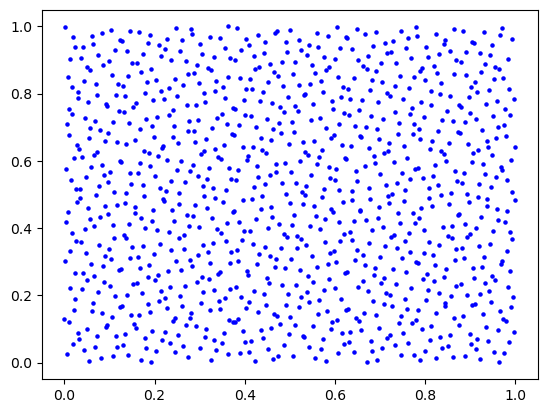

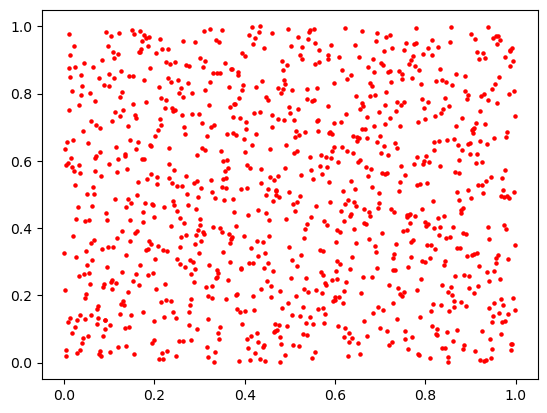

In [380]:
pippo = qmc.Sobol(2).random(1000)
lhs = LHS.random(1000)

plt.scatter(pippo[:, 0], pippo[:, 1], s=5, c="blue")
plt.show()
plt.scatter(lhs[:, 0], lhs[:, 1], s=5, c="red")
plt.show()


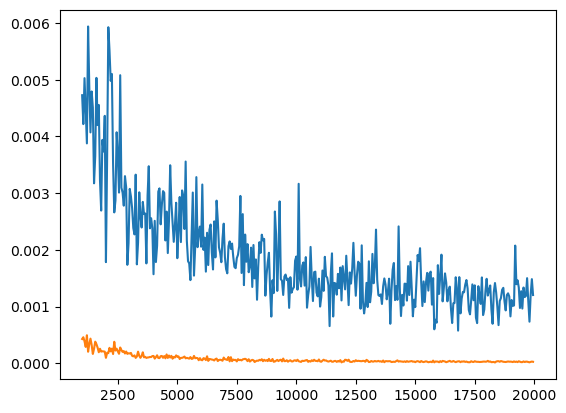

In [366]:

plt.plot(accrate[:, 0], accrate[:, 1])
plt.plot(accrate[:, 0], accrate[:, 2])
plt.show()

### Classic pi esteem with MCSimulation

In [ ]:
def circle(x):
    return np.where((x[0]-0.5)**2 + (x[1] - 0.5)**2 <= 0.25, 1, 0)

# plt.plot(tx, circle(tx))
N = 10000
xs = LHSampler(d = 2).random(N)
ys = np.apply_along_axis(circle, 1, xs)
inside = xs[ys == 1]
outside = xs[ys ==0]
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(inside[:, 0], inside[:, 1], s=3, c="red")
plt.scatter(outside[:, 0], outside[:, 1], s=3, c="blue")
plt.show()
## not finished yet


In [135]:
def graph(f, n = 1000, lim = [-1, 1], xs = None):
    fig, ax = plt.subplots(1,1)
    ax.set_xlim(lim[0])
    ax.set_ylim(lim[1])
    if xs is None:
        xs = np.linspace(lim[0], lim[1], n)
    ax.plot(xs, f(xs))


## SOBOL

In [97]:
# Define the complex function
def fun1(x):
    if type(x) is not list:
        x = [x]
    return np.exp(-np.sum((x - 1/np.arange(1, len(x)+1))**2)) * np.cos(np.sum(x))

def fun2(x):
    return -np.sin(x) + np.exp(- (x**2)) * np.cos(x)

# Define the integration domain and dimension
d = 1
domain = np.array([[-1, 1]] * d)

# Sampling methods (example with Sobol sequence)
sampler = qmc.Sobol(d)
samples = sampler.random_base2(m=15)  # 2^m samples
samples = qmc.scale(samples, domain[:, 0], domain[:, 1])  # Scale to domain

# Evaluate the function at sample points
values = np.apply_along_axis(fun2, 1, samples)

# Estimate the integral
integral_estimate = np.mean(values) * np.prod(domain[:, 1] - domain[:, 0])


print(f"Estimated Integral: {integral_estimate}")
# Repeat for different sampling methods and collect results


Estimated Integral: 1.3123487270237888


In [ ]:

lim, n = [-3, 3],1000
fig, ax = plt.subplots(1,1)
ax.set_xlim(lim)
xs = np.linspace(lim[0], lim[1], n)
ys = [fun1(x) for x in xs]
ax.plot(xs, ys)

# EXPERIMENT I 
## Grade Evolution

In [152]:
N, P = 1000, 2
exp1ss = LHSampler(d=P).random(N)

In [153]:

K = 4  # M ranges from N to K*N
ms = np.array((range(0, K*N + 1)), dtype=int)
ys = np.vectorize(lambda M: grade(exp1ss, M) + M/(N+M))(ms)


In [118]:
# data = np.column_stack((ms, ys)).tolist()
# expsave(
#     "exp1.grade_evol", 
#     {"S": exp1ss.tolist(), "data": data, "N": N, "P": P, "Mmin": 0, "Mmax": K*N},
#     "w", 
#     description="grade of the expansion of S in function of M. N = 1000; M ranges from N to K*N; K = 4")

In [165]:
dumped_data = expget("exp1.grade_evol")["datalist"][0]
data = np.array(dumped_data["data"])
ms, ys = data[:, 0], data[:, 1]
N, P = dumped_data["N"], dumped_data["P"] 
exp1ss = np.array(dumped_data["S"])

In [ ]:
usePlotSampleSet(exp1ss, s=2, c="blue")()

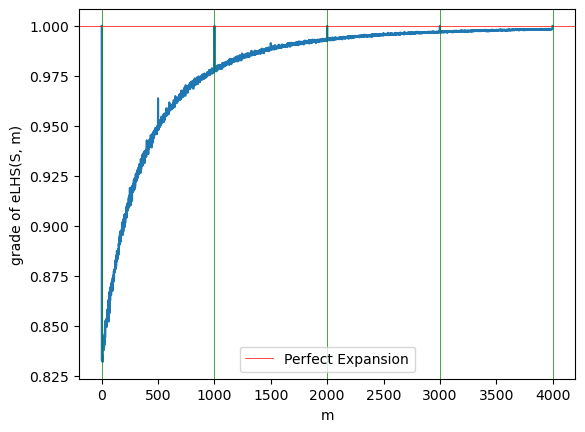

In [166]:
plt.plot(ms, ys)
plt.xlabel("m")
plt.ylabel("grade of eLHS(S, m)")
plt.axhline(1.0, color='red', linestyle='-', linewidth = 0.5, label = "Perfect Expansion")
for K in range(0, K + 1):
    plt.axvline(K * N, color='green', linestyle='-', linewidth = 0.5)
plt.legend()
plt.show()

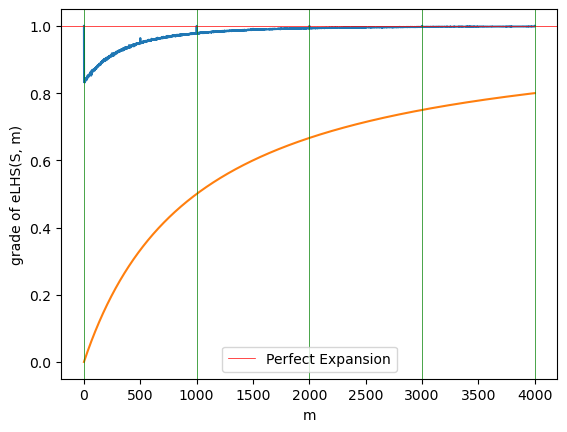

In [169]:
grmaxes = np.vectorize(lambda m: m/(N+m))(ms)
plt.plot(ms, ys)
plt.plot(ms, grmaxes)
plt.xlabel("m")
plt.ylabel("grade of eLHS(S, m)")
plt.axhline(1.0, color='red', linestyle='-', linewidth = 0.5, label = "Perfect Expansion")
for K in range(0, K + 1):
    plt.axvline(K * N, color='green', linestyle='-', linewidth = 0.5)
plt.legend()
plt.show()